In this notebook, we train the logistic regression models on the affinity sorting data (FACS1 vs. MACS1), score all the sequences, and select the top FACS1 sequences according to the model.

In [1]:
IPI_VH_SEQS = ['VH1-69']
IPI_VL_SEQS = ['VK1-39', 'VK3-15', 'VK3-20', 'VK4-01']
IPI_3_VL_SEQS = ['VK1-39', 'VK3-15', 'VK3-20']

sorts = [
    {
        "filename": "NGS_data/hROBO1_Test1_Lib31.csv",
        "SPR_antigens": ["hROBO1"],
        "SPR_antigens2": ["ROBO1"],
        "light": IPI_3_VL_SEQS,
        "heavy": IPI_VH_SEQS,
    },
    {
        "filename": "NGS_data/hROBO2N_Test1_Lib31.csv",
        "SPR_antigens": ["hROBO2N"],
        "SPR_antigens2": ["ROBO2N"],
        "light": IPI_3_VL_SEQS,
        "heavy": IPI_VH_SEQS,
    },
    {
        "filename": "NGS_data/PD1-L1_Test1_Lib31.csv",
        "SPR_antigens": ["PD1-L1", "PD1-L1_Test1_Lib31"],
        "SPR_antigens2": ["PDL1"],
        "light": IPI_3_VL_SEQS,
        "heavy": IPI_VH_SEQS,
    },
    {
        "filename": "NGS_data/hPD-L2_chase_Test1_Lib31.csv",
        "SPR_antigens": ["hPD-L2"],
        "SPR_antigens2": ["PDL2"],
        "light": IPI_3_VL_SEQS,
        "heavy": IPI_VH_SEQS,
    }
]

In [2]:
%%bash
# get the source data from zenodo
if [ ! -d ./zenodo_data ]; then
    wget https://zenodo.org/api/records/15367597/files-archive -O 15367597.zip
    unzip 15367597.zip -d ./zenodo_data
fi

In [3]:
import pandas as pd
import numpy as np
# %matplotlib inline
# %config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from Levenshtein import distance

In [4]:
import sklearn.linear_model as lm
from sklearn.metrics import roc_curve, auc
import scipy.stats as stats
import sklearn
sklearn.__version__

'1.6.1'

In [5]:
alphabet = "ACDEFGHIKLMNPQRSTVWY-"

def add_cdr3_gaps(s, max_len=20):
    s2 = s[1:]
    cut_len_L = min((len(s2)+1) // 2, max_len // 2)
    cut_len_R = min(len(s2) // 2, (max_len-1) // 2)
    gap_len = max_len - 1 - cut_len_L - cut_len_R
    s2 = s[0] + s2[:cut_len_L] + "-" * gap_len + s2[-cut_len_R:]
    return s2

def vectorize_cdr3(s, max_len=20):
    s = add_cdr3_gaps(s, max_len=max_len)
    v = np.zeros((len(s), len(alphabet)), dtype=np.int8)
    for i, c in enumerate(s):
        v[i, alphabet.index(c)] = 1
    return v

# print(add_cdr3_gaps("CARAPQYGLRYRDGYSAYFDI"))
# print(add_cdr3_gaps("CARAPQYGLRYDGYSAYFDI"))
# print(add_cdr3_gaps("CARAPQYGLRYGYSAYFDI"))
# print(add_cdr3_gaps("CARAPQYGLRGYSAYFDI"))
# print(add_cdr3_gaps("CARAPQYGLGYSAYFDI"))
# print(add_cdr3_gaps("CARAPQYGLGYSAYFD"))
# print(add_cdr3_gaps("CARHPYGSLHAFDY"))
assert len(add_cdr3_gaps("CARAPQYGLGYSAYFDI")) == 20
assert add_cdr3_gaps("CARAPQYGLGYSAYFDI").replace("-", "") == "CARAPQYGLGYSAYFDI"
# print(vectorize_cdr3("CARHPYGSLHAFDY"))

def cdr3_seqs_to_onehot(seqs, max_len=20):
    onehot_arr = np.zeros((len(seqs), max_len * len(alphabet)), dtype=np.float32)
    for i, seq in enumerate(seqs):
        onehot_arr[i] = vectorize_cdr3(seq).flatten()
        
    labels = [f"{i}{a}" for i in range(1, max_len+1) for a in alphabet]
    return onehot_arr, labels

def filter_cdr3(seqs: pd.Series):
#     return s[:3] == "CAR" and s[-3:] in {"FDY", "LDY", "FDI", "FDP"}
    return (seqs.str[:3] == "CAR") & seqs.str[-3:].isin({"FDY", "LDY", "FDI", "FDP"})

In [6]:
def get_kmer_list(seq, include_framework=''):
    if 'C' in include_framework:
        seq = 'C' + seq
    if 'W' in include_framework:
        seq = seq + 'W'
    kmer_counts = {}

    kmer_len = 1
    num_chunks = (len(seq)-kmer_len)+1
    for idx in range(0,num_chunks):
        kmer = seq[idx:idx+kmer_len]
        assert len(kmer) == kmer_len
        if kmer in kmer_counts:
            kmer_counts[kmer] += 1
        else:
            kmer_counts[kmer] = 1

    kmer_len = 2
    num_chunks = (len(seq)-kmer_len)+1
    for idx in range(0,num_chunks):
        kmer = seq[idx:idx+kmer_len]
        assert len(kmer) == kmer_len
        if kmer in kmer_counts:
            kmer_counts[kmer] += 1
        else:
            kmer_counts[kmer] = 1

    kmer_len = 3
    num_chunks = (len(seq)-kmer_len)+1
    for idx in range(0,num_chunks):
        kmer = seq[idx:idx+kmer_len]
        assert len(kmer) == kmer_len
        if kmer in kmer_counts:
            kmer_counts[kmer] += 1
        else:
            kmer_counts[kmer] = 1
    #print kmer_counts
    return [(key,val) for key,val in kmer_counts.items()]

In [7]:
cdr3_alphabet = 'ACDEFGHIKLMNPQRSTVWY'
kmer_to_idx = {}
counter = 0
kmer_list = [aa for aa in cdr3_alphabet]
for aa in cdr3_alphabet:
    for bb in cdr3_alphabet:
        kmer_list.append(aa+bb)
        for cc in cdr3_alphabet:
            kmer_list.append(aa+bb+cc)

kmer_to_idx = {aa: i for i, aa in enumerate(kmer_list)}

In [8]:
def cdr3_seqs_to_arr(seqs, include_framework=''):
    seq_to_kmer_vector = {}
    for seq in seqs:
        # Make into kmers
        kmer_data_list = get_kmer_list(seq, include_framework=include_framework)
        norm_val = 0.
        for kmer,count in kmer_data_list:
            count = float(count)
            norm_val += (count * count)
        norm_val = np.sqrt(norm_val)

        # L2 normalize
        final_kmer_data_list = []
        for kmer,count in kmer_data_list:
            final_kmer_data_list.append((kmer_to_idx[kmer],float(count)/norm_val))

        # save to a dictionary
        seq_to_kmer_vector[seq] = final_kmer_data_list

    kmer_arr = np.zeros((len(seqs), len(kmer_to_idx)), dtype=np.float32)
    for i, seq in enumerate(seqs):
        kmer_vector = seq_to_kmer_vector[seq]
        for j_kmer,val in kmer_vector:
            kmer_arr[i, j_kmer] = val
    return kmer_arr

In [9]:
def normalize_abundance(df, col):
    s = df[col].fillna(0)
    s = (s / s.sum()) * 1e6
    s[s < 1] = 1
    return s

# def filter_rounds(df, cols):
#     return df[(df[cols] > 5).any(axis=1)]

def calc_enrichment(df, col1, col2, col1_min=None, col2_min=None):
    s1, s2 = normalize_abundance(df, col1), normalize_abundance(df, col2)
    enrichment = np.log(s2) - np.log(s1)
    if col1_min is not None and col2_min is not None:
        enrichment[(df[col1].fillna(0) < col1_min) & (df[col2].fillna(0) < col2_min)] = 0
    elif col1_min is not None:
        enrichment[df[col1].fillna(0) < col1_min] = 0
    elif col2_min is not None:
        enrichment[df[col2].fillna(0) < col2_min] = 0
#     enrichment[(df[[col1, col2]].fillna(0) < 2).all(axis=1)] = 0
    return enrichment

In [10]:
print("a1/m1", "a2/m1", "a3/m1", "a2/a1", "a3/a1", "file", sep='\t')
for fname in [
    "NGS_data/hROBO1_Test1_Lib31.csv",
    "NGS_data/hROBO2N_Test1_Lib31.csv",
    "NGS_data/PD1-L1_Test1_Lib31.csv",
    "NGS_data/hPD-L2_chase_Test1_Lib31.csv",
]:
    df = pd.read_csv(fname)
    df = df[filter_cdr3(df["CDR3"])]
    
    df["Aff1_Macs1"] = calc_enrichment(df, "Macs1", "Aff1")
    df["Aff2_Macs1"] = calc_enrichment(df, "Macs1", "Aff2")
    df["Aff2_Aff1"] = calc_enrichment(df, "Aff1", "Aff2")
    df["Aff3_Macs1"] = calc_enrichment(df, "Macs1", "Aff2")
    df["Aff3_Aff1"] = calc_enrichment(df, "Aff1", "Aff3")
    df["Aff3_Aff2"] = calc_enrichment(df, "Aff2", "Aff3")
    
    print((df["Aff1_Macs1"] != 0).sum(), (df["Aff2_Macs1"] != 0).sum(), (df["Aff3_Macs1"] != 0).sum(), (df["Aff3_Aff1"] != 0).sum(), (df["Aff3_Aff1"] != 0).sum(), fname, sep='\t')
#     assert len(df[(df["Aff1_Macs1"] != 0) & ((df["Macs1"] < 5) | df["Macs1"].isnull()) & ((df["Aff1"] < 5) | df["Aff1"].isnull())]) == 0

a1/m1	a2/m1	a3/m1	a2/a1	a3/a1	file
100663	94710	94710	8073	8073	NGS_data/hROBO1_Test1_Lib31.csv
82896	78191	78191	5946	5946	NGS_data/hROBO2N_Test1_Lib31.csv
106513	90489	90489	20029	20029	NGS_data/PD1-L1_Test1_Lib31.csv
81046	72513	72513	9726	9726	NGS_data/hPD-L2_chase_Test1_Lib31.csv


# Logistic regression

### use kmer representations

For each sort, train an LR model using CDR3 k-mers + VL gene identities, then score all the antibody sequences in that sort using the model.

a1/m1	a2/m1	a3/m1	a2/a1	order	file
73949	69503	69503	6262	48	NGS_data/hROBO1_Test1_Lib31.csv
75463
['VK1-39', 'VK3-15', 'VK3-20', 'VK4-01']
Categories (4, object): ['VK1-39' < 'VK3-15' < 'VK3-20' < 'VK4-01']
59159 4794 Train
14790 1198 Test
69503 1432 Aff3 Val
48 43 SPR Val


/Users/aaron/mambaforge/envs/py312/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.1.3 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Train AUC: 0.794523075055383
Test AUC: 0.6631962015366006
Aff3/Macs1 AUC: 0.9159257414354336
Aff3 Spearman: 0.23463426504910534
SPR AUC: 0.5813953488372092

PFY    21.307608
QVL    14.558972
WGD    14.149847
API    12.557590
IQF    12.136298
         ...    
GIL    -9.274755
PTR    -9.972542
GLP   -10.024251
LFY   -10.511548
NWF   -11.509653
Length: 1546, dtype: float64
A        -0.959996
C         7.692133
F        -0.790630
H        -1.172612
I        -0.973145
            ...   
YWQ      -1.647676
YWR       1.425912
YWY      -8.907101
VK1-39    0.026482
VK3-15    0.050375
Length: 1546, dtype: float64


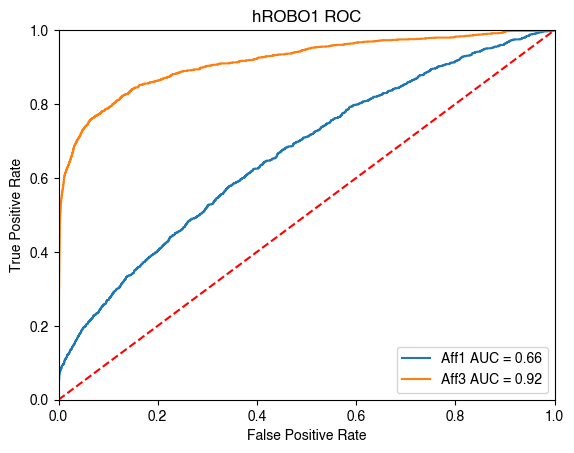

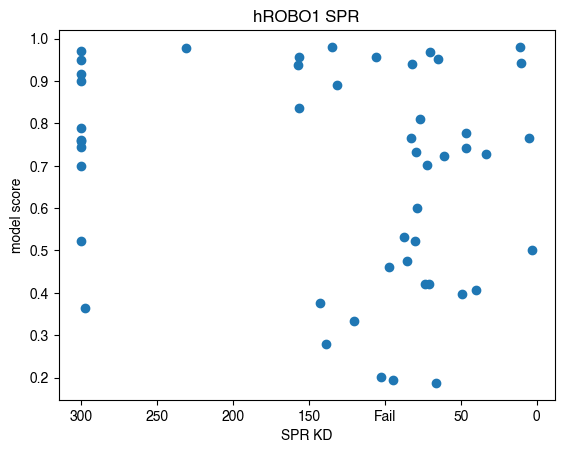

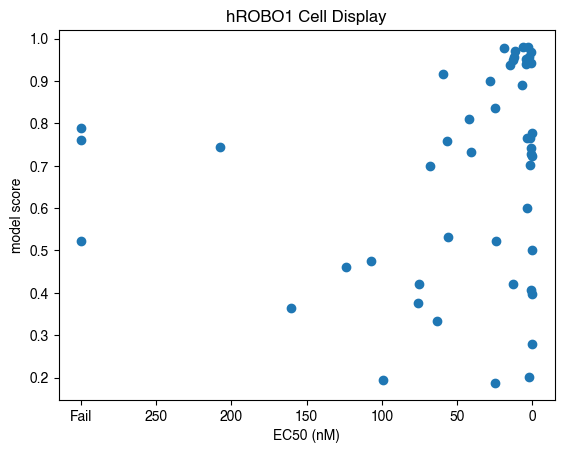

61111	57504	57504	4612	36	NGS_data/hROBO2N_Test1_Lib31.csv
62022
['VK1-39', 'VK3-15', 'VK3-20', 'VK4-01']
Categories (4, object): ['VK1-39' < 'VK3-15' < 'VK3-20' < 'VK4-01']
48888 3682 Train
12223 903 Test
57504 870 Aff3 Val
36 19 SPR Val


/Users/aaron/mambaforge/envs/py312/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.1.3 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Train AUC: 0.8331138380034108
Test AUC: 0.6996523171681361
Aff3/Macs1 AUC: 0.9318763067878075
Aff3 Spearman: 0.33481788334525603
SPR AUC: 0.5975232198142414

WGD    18.110673
STH    14.321093
WGN    13.247707
AIG    12.726136
HNV    12.561655
         ...    
SAW   -10.272141
NRF   -10.310463
IAF   -10.552572
REW   -10.619279
SPV   -11.633461
Length: 1424, dtype: float64
A        -0.769192
C         8.938137
D        -0.084696
E        -0.340783
F         0.254216
            ...   
YWI      -5.128428
YWL       5.268954
YWY      -3.482901
VK1-39   -0.204287
VK3-20   -0.174658
Length: 1424, dtype: float64


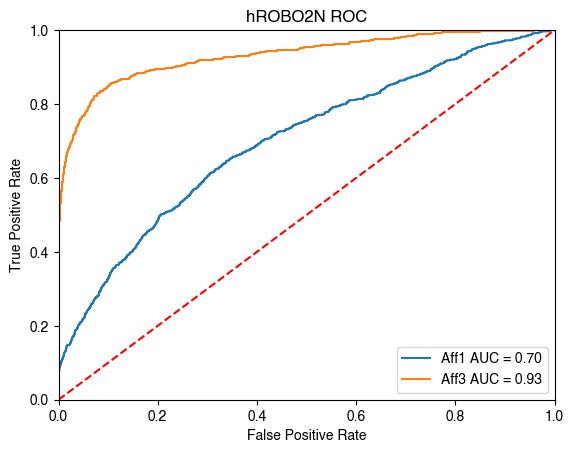

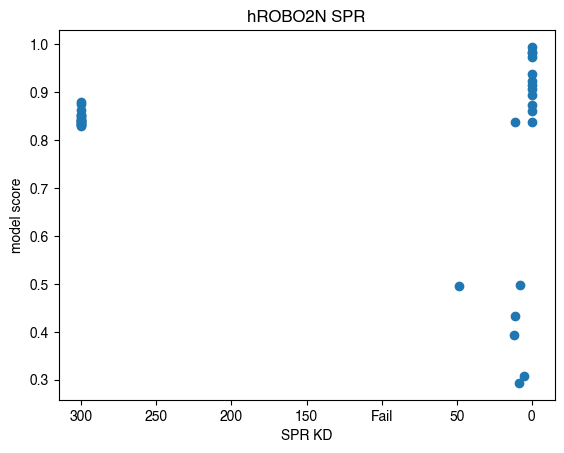

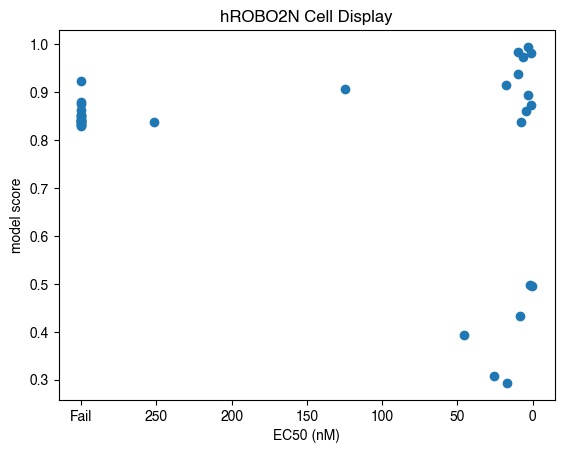

82790	69791	69791	16269	38	NGS_data/PD1-L1_Test1_Lib31.csv
84341
['VK1-39', 'VK3-15', 'VK3-20', 'VK4-01']
Categories (4, object): ['VK1-39' < 'VK3-15' < 'VK3-20' < 'VK4-01']
66232 12648 Train
16558 3199 Test
69791 978 Aff3 Val
38 31 SPR Val


/Users/aaron/mambaforge/envs/py312/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.1.3 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Train AUC: 0.6512903097731931
Test AUC: 0.5757427190233043
Aff3/Macs1 AUC: 0.7933794195269792
Aff3 Spearman: 0.09264129055755473
SPR AUC: 0.566820276497696

AQD    5.207794
WGL    5.143393
SEQ    4.927817
TRI    4.644377
FSR    4.586292
         ...   
FGV   -4.285728
FSD   -4.499371
DEG   -4.694804
WVD   -5.045563
AWA   -5.071931
Length: 998, dtype: float64
A        -0.287565
C         1.220832
D         0.309183
E        -0.534260
F         0.660046
            ...   
YWR       3.661661
YWS      -1.121323
YWT      -1.777465
VK3-15   -0.105412
VK3-20   -0.058762
Length: 998, dtype: float64


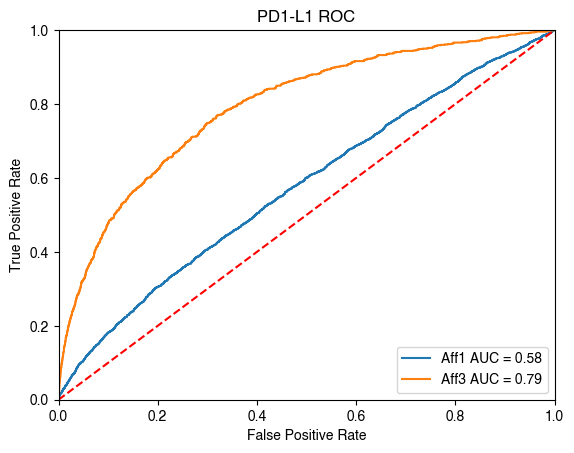

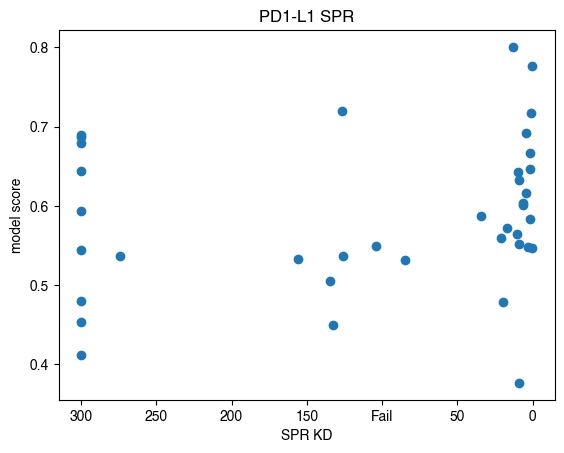

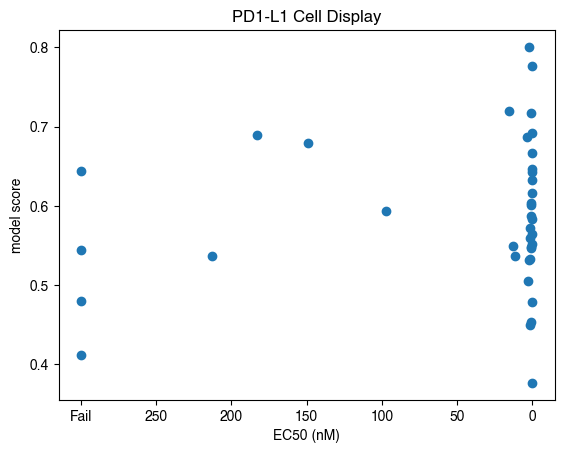

61588	54902	54902	7724	54	NGS_data/hPD-L2_chase_Test1_Lib31.csv
62660
['VK1-39', 'VK3-15', 'VK3-20', 'VK4-01']
Categories (4, object): ['VK1-39' < 'VK3-15' < 'VK3-20' < 'VK4-01']
49270 6032 Train
12318 1525 Test
54902 714 Aff3 Val
54 23 SPR Val
Train AUC: 0.7626706588099206
Test AUC: 0.6788165371301678
Aff3/Macs1 AUC: 0.8250737550501118
Aff3 Spearman: 0.13653758402634147
SPR AUC: 0.5287517531556802

VLE    9.695639
VPR    8.418411
PVQ    7.597999
IAR    7.380994
SHR    7.256189
         ...   
DVF   -6.772670
PAS   -6.884430
LAT   -7.259585
VIS   -7.730480
RTQ   -9.232288
Length: 1140, dtype: float64
A        -0.169116
C         5.398801
E        -0.208189
F         0.177722
G        -0.018439
            ...   
YWR       1.731374
YWY      -1.120251
YY        2.294834
VK3-15    0.008635
VK3-20    0.054195
Length: 1140, dtype: float64


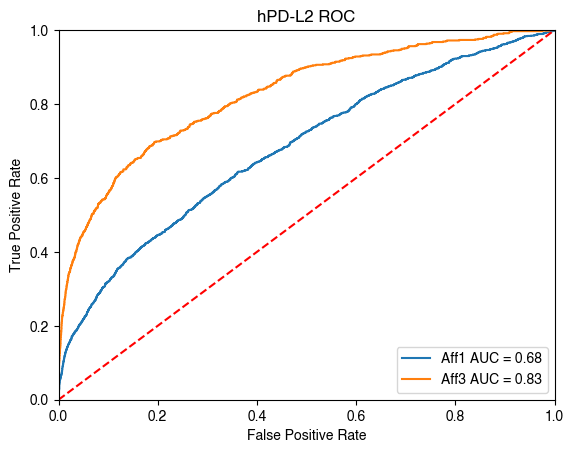

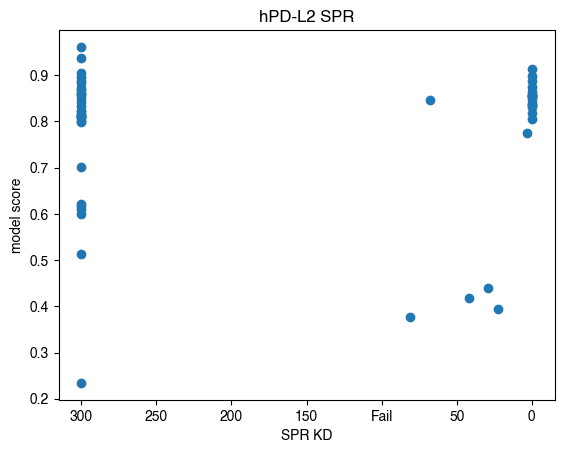

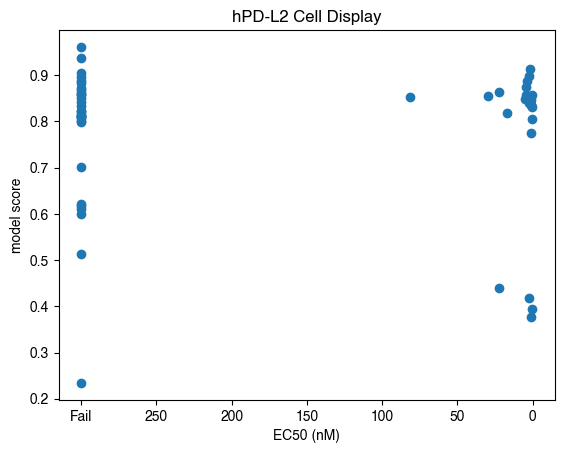

In [11]:
results = []

print("a1/m1", "a2/m1", "a3/m1", "a2/a1", "order", "file", sep='\t')
for sort in sorts:
    fname = sort["filename"]
    target = fname.rsplit("/", 1)[1].split("_", 1)[0]
    light_chains = sort["light"]
    heavy_chains = sort["heavy"]
    antigens = sort["SPR_antigens"]
    antigens2 = sort["SPR_antigens2"]
    params_file = f"params/{fname.rsplit('/', 1)[1].replace('.csv', '')}_kmer_LR.pkl"
    aff3_file = f"scores/{fname.rsplit('/', 1)[1].replace('.csv', '')}_kmer_aff3_scores.csv"
    
    df = pd.read_csv(fname)
    df = df[filter_cdr3(df["CDR3"])]
    df = df[df["light"].isin(light_chains)]
    df = df[df["heavy"].isin(heavy_chains)]
    
    if "Macs1" not in df.columns:
        df["Macs1"] = df["Macs1_A1"]
        df["Aff1"] = df["Aff1_A1"]
        df["Aff2"] = df["Aff2_A1"]
        df["Aff3"] = df["Aff3_Combined"]
    
    df["Aff1_Macs1"] = calc_enrichment(df, "Macs1", "Aff1")
    df["Aff2_Macs1"] = calc_enrichment(df, "Macs1", "Aff2")
    df["Aff2_Aff1"] = calc_enrichment(df, "Aff1", "Aff2")
    df["Aff3_Macs1"] = calc_enrichment(df, "Macs1", "Aff2")
    df["Aff3_Aff1"] = calc_enrichment(df, "Aff1", "Aff3")
    df["Aff3_Aff2"] = calc_enrichment(df, "Aff2", "Aff3")

    char_df = pd.read_csv("zenodo_data/00Library_Biophysics_486Abs(1).csv", header=0, skiprows=1, names="Antibody_Name	Antigen	HC	LC	CDRH3	FACS1 count	FACS2 count	FACS3 count	PSR	SEC	SPR KD	SPR ka	SPR kdis (1/s)	Cell Display EC50".split('\t'))
    char_df["key"] = char_df["CDRH3"] + ":" + char_df["HC"] + ":" + char_df["LC"]
    char_df = char_df[char_df["Antigen"].isin(antigens2)]
    char_df["SPR KD"] = char_df["SPR KD"].replace("Fail", 1000).astype(float)
    char_df["Cell Display EC50"] = char_df["Cell Display EC50"].replace("Fail", 1000).astype(float)
    
    df = pd.merge(df, char_df, on="key", how="left")

    print((df["Aff1_Macs1"] != 0).sum(), (df["Aff2_Macs1"] != 0).sum(), (df["Aff3_Macs1"] != 0).sum(), (df["Aff3_Aff1"] != 0).sum(), len(char_df), fname, sep='\t')
    #     assert len(df[(df["Aff1_Macs1"] != 0) & ((df["Macs1"] < 5) | df["Macs1"].isnull()) & ((df["Aff1"] < 5) | df["Aff1"].isnull())]) == 0

    kmer_arr = cdr3_seqs_to_arr(df['CDR3'], include_framework='W')
    # vh_onehot = pd.get_dummies(pd.Categorical(df['heavy'], categories=IPI_VH_SEQS_V2, ordered=True))
    vl_onehot = pd.get_dummies(pd.Categorical(df['light'], categories=IPI_VL_SEQS, ordered=True))
    length_onehot = pd.get_dummies(pd.Categorical(df['CDR3'].str.len(), ordered=True))
    print(len(df))
    # print(vh_onehot.columns.values)
    print(vl_onehot.columns.values)
    kmer_vh_vl_arr = np.concatenate([
        kmer_arr, 
    #     vh_onehot.values,
        vl_onehot.values
    ], axis=1)
    kmer_vh_vl_len_arr = np.concatenate([kmer_vh_vl_arr, length_onehot.values], axis=1)
    kmer_arr_labels = kmer_list
    kmer_vh_vl_arr_labels = (
        kmer_arr_labels +
    #     vh_onehot.columns.tolist() +
        vl_onehot.columns.tolist()
    )
    kmer_vh_vl_len_arr_labels = kmer_vh_vl_arr_labels + length_onehot.columns.tolist()
    
    char_kmer_arr = cdr3_seqs_to_arr(char_df['CDRH3'], include_framework='W')
    char_vl_onehot = pd.get_dummies(pd.Categorical(char_df['LC'], categories=IPI_VL_SEQS, ordered=True))
    char_kmer_vh_vl_arr = np.concatenate([
        char_kmer_arr, 
        char_vl_onehot.values
    ], axis=1)

    X, X_labels, y = kmer_vh_vl_arr, kmer_vh_vl_arr_labels, df["Aff1_Macs1"].values
    X = pd.DataFrame(X, columns=X_labels)
    X, y = X[y != 0], y[y != 0]
    np.random.seed(1)
    msk = np.random.permutation(len(y)) < int(len(y) * 0.8)
    X_train, X_test = X[msk], X[~msk]
    y_train, y_test = y[msk], y[~msk]
    print(len(y_train), (y_train > 0).sum(), "Train")
    print(len(y_test), (y_test > 0).sum(), "Test")

    X_val, y_val = kmer_vh_vl_arr, df["Aff3_Macs1"].values
    X_val = pd.DataFrame(X_val, columns=X_labels)
    X_val, y_val = X_val[y_val != 0], y_val[y_val != 0]
    print(len(y_val), (y_val > 0).sum(), "Aff3 Val")

    X_val2, y_val2 = char_kmer_vh_vl_arr, ((char_df["SPR KD"] < 100) | (char_df["Cell Display EC50"] < 100))
    X_val2 = pd.DataFrame(X_val2, columns=X_labels)
    print(len(y_val2), (y_val2 > 0).sum(), "SPR Val")

    # train model
    thresh = 0.
    if os.path.exists(params_file):
        with open(params_file, "rb") as f:
            clf = pickle.load(f)
    else:
        clf = lm.LogisticRegression(random_state=42, penalty='l1', C=1., class_weight='balanced', solver='liblinear').fit(X_train, y_train > thresh)
        with open(params_file, "wb") as f:
            pickle.dump(clf, f)

    y_score_train = clf.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train > 0, y_score_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    print("Train AUC:", roc_auc_train)

    y_score = clf.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test > 0, y_score)
    roc_auc_test = auc(fpr_test, tpr_test)
    print("Test AUC:", roc_auc_test)

    y_score_val = clf.predict_proba(X_val)[:, 1]
    fpr_val, tpr_val, _ = roc_curve(y_val > 0, y_score_val)
    roc_auc_aff3_macs1 = auc(fpr_val, tpr_val)
    print("Aff3/Macs1 AUC:", roc_auc_aff3_macs1)

    X, X_labels, y = kmer_vh_vl_arr, kmer_vh_vl_arr_labels, df["Aff3"].values
    X = pd.DataFrame(X, columns=X_labels)
#     X, y = X[y > 0], y[y > 0]
    y_score = clf.predict_proba(X)[:, 1]
    spearman_aff3 = stats.spearmanr(y_score[y > 0], y[y > 0])[0]
    print("Aff3 Spearman:", spearman_aff3)
    save_df = df.copy()
#     save_df = save_df[save_df["Aff3"] > 0]
    save_df["LR_score"] = y_score
    save_df.to_csv(aff3_file, index=False)
    
    if len(y_val2) != 0:
        y_score_val2 = clf.predict_proba(X_val2)[:, 1]
        fpr_val2, tpr_val2, _ = roc_curve(y_val2 > 0, y_score_val2)
        roc_auc_spr = auc(fpr_val2, tpr_val2)
        print("SPR AUC:", roc_auc_spr)
    
    print()
    coefs = pd.Series(index=clf.feature_names_in_, data=clf.coef_[0])
    print(coefs[coefs != 0].sort_values(ascending=False))
    print(coefs[coefs != 0])
    
    results.append(dict(
        fname=fname,
        n_params=clf.coef_.shape[1],
        nonzero_params=(clf.coef_ != 0).sum(),
        roc_auc_train=roc_auc_train,
        roc_auc_test=roc_auc_test,
        spearman_aff3=spearman_aff3,
        roc_auc_aff3_macs1=roc_auc_aff3_macs1,
        roc_auc_spr=roc_auc_spr,
        train_size=len(y_train),
        train_positive=(y_train > 0).sum(),
        test_size=len(y_test),
        test_positive=(y_test > 0).sum(),
        aff3_size=len(y_val),
        aff3_positive=(y_val > 0).sum(),
        spr_size=len(y_val2),
        spr_positive=(y_val2 > 0).sum(),
    ))
    
    # method I: plt
    plt.title(f"{target} ROC")
    plt.plot(fpr_test, tpr_test, 'C0', label = 'Aff1 AUC = %0.2f' % roc_auc_test)
    plt.plot(fpr_val, tpr_val, 'C1', label = 'Aff3 AUC = %0.2f' % roc_auc_aff3_macs1)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    fig, ax = plt.subplots()
    plt.title(f"{target} SPR")
    plt.scatter(char_df["SPR KD"].mask(lambda col: col > 300, 300), y_score_val2)
    ax.invert_xaxis()
    plt.ylabel("model score")
    plt.xlabel("SPR KD")
    fig.canvas.draw()
    labels = [item.get_text() for item in ax.get_xmajorticklabels()]
    labels = ["Fail" if item == "100" else item for item in labels]
    ax.set_xticks(ax.get_xticks(minor=False)[1:-1])
    ax.set_xticklabels(labels[1:-1])
    plt.show()

    fig, ax = plt.subplots()
    plt.title(f"{target} Cell Display")
    plt.scatter(char_df["Cell Display EC50"].mask(lambda col: col > 300, 300), y_score_val2)
    plt.gca().invert_xaxis()
    plt.ylabel("model score")
    plt.xlabel("EC50 (nM)")
    fig.canvas.draw()
    labels = [item.get_text() for item in ax.get_xmajorticklabels()]
    labels = ["Fail" if item == "300" else item for item in labels]
    ax.set_xticks(ax.get_xticks(minor=False)[1:-1])
    ax.set_xticklabels(labels[1:-1])
    plt.show()

In [12]:
results_df = pd.DataFrame(results)
results_df["fname"] = results_df["fname"].str.split("/").str[-1]
results_df

,fname,n_params,nonzero_params,roc_auc_train,roc_auc_test,spearman_aff3,roc_auc_aff3_macs1,roc_auc_spr,train_size,train_positive,test_size,test_positive,aff3_size,aff3_positive,spr_size,spr_positive
0,hROBO1_Test1_Lib31.csv,8424,1546,0.794523,0.663196,0.234634,0.915926,0.581395,59159,4794,14790,1198,69503,1432,48,43
1,hROBO2N_Test1_Lib31.csv,8424,1424,0.833114,0.699652,0.334818,0.931876,0.597523,48888,3682,12223,903,57504,870,36,19
2,PD1-L1_Test1_Lib31.csv,8424,998,0.651290,0.575743,0.092641,0.793379,0.566820,66232,12648,16558,3199,69791,978,38,31
3,hPD-L2_chase_Test1_Lib31.csv,8424,1140,0.762671,0.678817,0.136538,0.825074,0.528752,49270,6032,12318,1525,54902,714,54,23


In [13]:
results_df[["roc_auc_aff3_macs1", "roc_auc_spr"]].mean()

roc_auc_aff3_macs1    0.866564
roc_auc_spr           0.568623
dtype: float64

# select sequences

Use the logistic regression model to select sequences from the FACS1 pool according to their read fraction, model score, and distance from other sequences.

In [14]:
def min_levenshtein(seq1, seqs):
    return min(distance(seq1, s, score_cutoff=len(seq1)) for s in seqs)

def min_pairwise_levenshtein(seqs):
    prev_cdr3s = [""]
    distances = []
    for cdr3 in seqs:
        distances.append(min_levenshtein(cdr3, prev_cdr3s))
        prev_cdr3s.append(cdr3)
    return distances

In [15]:
min_aff1_frac = 1 / 5000
min_lr_score = 0.8
min_dist_to_ordered = 5
min_pairwise_dist = 3

In [16]:
results = []

for sort in sorts:
    fname = sort["filename"]
    target = fname.rsplit("/", 1)[1].split("_", 1)[0]
    light_chains = sort["light"]
    heavy_chains = sort["heavy"]
    antigens = sort["SPR_antigens"]
    params_file = f"params/{fname.rsplit('/', 1)[1].replace('.csv', '')}_kmer_LR.pkl"
    aff3_file = f"scores/{fname.rsplit('/', 1)[1].replace('.csv', '')}_kmer_aff3_scores.csv"
    output_file = f"selected_abs/aff1_subset_kmer_LR_{fname.rsplit('/', 1)[1].replace('.csv', '')}.csv"
    if fname not in [
        "NGS_data/hROBO1_Test1_Lib31.csv",
        "NGS_data/hROBO2N_Test1_Lib31.csv",
    ]:
        continue
    
    print(fname)

    df = pd.read_csv(aff3_file, low_memory=False)
    ordered_set = df[df["SEC"].notnull()]
    
    min_aff1_frac = 1 / 5000
    min_lr_score = 0.8
    min_dist_to_ordered = 5
    min_pairwise_dist = 5 if fname != "NGS_data/hPD-L2_chase_Test1_Lib31.csv" else 3

    subset_df = df[(df["Aff1"] > df["Aff1"].sum() * min_aff1_frac) & df["SEC"].isnull() & (df["LR_score"] > min_lr_score)].sort_values(by="LR_score", ascending=False)
    subset_df["min_dist_to_ordered"] = subset_df["CDR3"].apply(min_levenshtein, args=(ordered_set["CDR3"],))
    subset_df = subset_df[subset_df["min_dist_to_ordered"] >= min_dist_to_ordered]


    subset_df["min_pairwise_dist"] = min_pairwise_levenshtein(subset_df["CDR3"].values)
    subset_df = subset_df[subset_df["min_pairwise_dist"] >= min_pairwise_dist]
    subset_df.to_csv(output_file, index=False)

    with pd.option_context("display.max_rows", 200):
        display(subset_df)

NGS_data/hROBO1_Test1_Lib31.csv


,CDR3,heavy,light,key,Macs1,Aff1,Aff2,Aff3,Aff1_Macs1,Aff2_Macs1,...,FACS3 count,PSR,SEC,SPR KD,SPR ka,SPR kdis (1/s),Cell Display EC50,LR_score,min_dist_to_ordered,min_pairwise_dist
791,CARARGPFYVYWGYPFDP,VH1-69,VK3-15,CARARGPFYVYWGYPFDP:VH1-69:VK3-15,1.0,36.0,69.0,NaN,3.711162,4.066354,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.980102,7,18
2508,CARESTPFYFPRAGFDY,VH1-69,VK3-20,CARESTPFYFPRAGFDY:VH1-69:VK3-20,NaN,18.0,35.0,NaN,5.643895,6.013476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.975114,6,10
2843,CARGFGPFYTSYSGSFDP,VH1-69,VK3-20,CARGFGPFYTSYSGSFDP:VH1-69:VK3-20,NaN,21.0,71.0,NaN,5.798046,6.720808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.973358,7,7
612,CARALGPFYRSYAGVFDP,VH1-69,VK3-20,CARALGPFYRSYAGVFDP:VH1-69:VK3-20,NaN,31.0,199.0,NaN,6.187511,7.751433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.971060,6,5
3648,CARGVRPFYWGLSYAFDI,VH1-69,VK3-20,CARGVRPFYWGLSYAFDI:VH1-69:VK3-20,NaN,29.0,6.0,NaN,6.120819,4.249888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.967599,7,8
1844,CARDRWPFYGYGRYIFDY,VH1-69,VK1-39,CARDRWPFYGYGRYIFDY:VH1-69:VK1-39,NaN,13.0,3.0,NaN,5.318473,3.556741,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.965518,7,7
781,CARARGPFYRSSGDYFDP,VH1-69,VK3-20,CARARGPFYRSSGDYFDP:VH1-69:VK3-20,NaN,22.0,12.0,NaN,5.844566,4.943035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964649,5,5
1981,CARDYDPFYRSAVHAFDP,VH1-69,VK3-20,CARDYDPFYRSAVHAFDP:VH1-69:VK3-20,NaN,33.0,39.0,NaN,6.250031,6.121690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.963160,6,7
345,CARAAGPFYLRDRWVFDI,VH1-69,VK3-20,CARAAGPFYLRDRWVFDI:VH1-69:VK3-20,NaN,31.0,18.0,NaN,6.187511,5.348500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.961222,6,7
3243,CARGQSPFYGKSTYAFDY,VH1-69,VK3-20,CARGQSPFYGKSTYAFDY:VH1-69:VK3-20,NaN,35.0,313.0,NaN,6.308872,8.204332,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.960431,6,6


NGS_data/hROBO2N_Test1_Lib31.csv


,CDR3,heavy,light,key,Macs1,Aff1,Aff2,Aff3,Aff1_Macs1,Aff2_Macs1,...,FACS3 count,PSR,SEC,SPR KD,SPR ka,SPR kdis (1/s),Cell Display EC50,LR_score,min_dist_to_ordered,min_pairwise_dist
4123,CARVEKSYWGNAFDY,VH1-69,VK3-15,CARVEKSYWGNAFDY:VH1-69:VK3-15,1.0,45.0,93.0,NaN,3.765934,3.972698,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.986992,5,15
3873,CARTAIRNYWGDAFDY,VH1-69,VK3-15,CARTAIRNYWGDAFDY:VH1-69:VK3-15,NaN,13.0,234.0,NaN,5.328127,7.699326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.973728,5,6
2661,CARHGYSSASYWGDAFDY,VH1-69,VK3-15,CARHGYSSASYWGDAFDY:VH1-69:VK3-15,NaN,47.0,12.0,NaN,6.613325,4.728912,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.970409,6,5
4,CARNVEKFYAGAGFDY,VH1-69,VK3-15,CARNVEKFYAGAGFDY:VH1-69:VK3-15,NaN,69.0,1454.0,350.0,6.997284,9.526079,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.961205,6,5
2067,CARGQWIFDY,VH1-69,VK3-15,CARGQWIFDY:VH1-69:VK3-15,NaN,20.0,409.0,NaN,5.758909,8.257720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.921146,6,7
227,CARALVAWYSGDAFDY,VH1-69,VK3-15,CARALVAWYSGDAFDY:VH1-69:VK3-15,NaN,16.0,NaN,NaN,5.535766,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.862276,5,6
409,CARAVERYISGSGFDY,VH1-69,VK3-15,CARAVERYISGSGFDY:VH1-69:VK3-15,NaN,34.0,1277.0,NaN,6.289538,9.396274,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.853856,5,6
288,CARAQGAKYVAWGDAFDY,VH1-69,VK3-15,CARAQGAKYVAWGDAFDY:VH1-69:VK3-15,NaN,20.0,35.0,NaN,5.758909,5.799353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.852412,5,6
6,CARGVESYFTGTGFDP,VH1-69,VK3-15,CARGVESYFTGTGFDP:VH1-69:VK3-15,NaN,197.0,321.0,129.0,8.046381,8.015446,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.850126,5,6
2758,CARHVESYASGSAFDI,VH1-69,VK3-15,CARHVESYASGSAFDI:VH1-69:VK3-15,NaN,17.0,NaN,NaN,5.596390,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.842153,5,5
